# Exercises: Working with the Microphone

In this notebook, we will learn how to access the digitized audio recording our microphones, and access the audio samples as a numpy array of data that we can analyze and manipulate.
We will write functions for writing and reading our own numpy-based audio files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from typing import Tuple

# %matplotlib notebook
%matplotlib inline

As discussed in the [preceding section](https://rsokl.github.io/CogWeb/Audio/digitizing_signals.html), a microphone is responsible for converting the information carried by sound waves into an analog electrical signal, which it then digitizes through a process comparable to pulse code modulation (PCM). 
Let's take some time to understand how we can access the digital audio samples that are recorded by your microphone. 

Your microphone stores the audio on buffer frames, which is just an area of RAM made for temporary storage.
Buffers are typically used when there is a difference between the rate at which data is received and the rate at which it can be processed.
The details of buffer frames are not especially important though.
We only need to know that our digital signal will be stored as a collection of bytes in memory across a number of frames.

## Using the Microphone Python Package
The `microphone.record_audio` package records and digitizes an analog signal and returns a tuple containing 

1. a list of bytes in memory corresponding to the digital signal 
2. the sampling rate.

(Remember that, in a Jupyter Notebook, you can check this by inspecting the function's docstring with `SHIFT-TAB`)

For example, consider the following code

```python
from microphone import record_audio
listen_time = 5  # seconds
frames, sample_rate = record_audio(listen_time)
```

Here `sample_rate` is the sampling rate, $f_s$, used by the microphone to record the digital signal.
Since all we need to know in order to reconstruct the original signal from bytes in memory are the sampling rate and the number of samples, it is extremely important that we keep track of `sample_rate`!

(1.2.1) Use the `record_audio` function to record and digitize an analog signal that lasts five seconds.

In [2]:
from microphone import record_audio

listen_time = 5 # seconds
frames, sample_rate = record_audio(listen_time) # record audio for the listen time

Using input device 'External Microphone'
Recording ended


The `frames` variable is a list of bytes in memory that compose the entirety of the recorded digital signal.
To anyone except a computer, the elements of `frames` are indecipherable;
just try inspecting the first 15 elements of `frames[0]`.

In [3]:
# print:
# - sample_rate
# - len(frames)  <- the number of frames
# - len(frames[0])  <- the number of bytes in frame 0
# - frames[0][:15]  <- the first 15 bytes in frame 0

# STUDENT CODE HERE
print(sample_rate)
print(len(frames))
print(len(frames[0]))
print(frames[0][:15])

44100
215
2048
b'\x15\x00\x11\x00\x14\x00#\x00#\x00\x19\x00\x1a\x00\x16'


To make the data useful to us, we will need to convert each of the bytes into $16$-bit integers, under the assumption that the microphone used the standard bit depth of $N_b=16$.
To do so, we can use the [numpy.frombuffer](https://numpy.org/doc/1.18/reference/generated/numpy.frombuffer.html) function. In particular,

```python
np.frombuffer(frames[0], np.int16)
```

will read in the first frame and return a 1-D NumPy array containing $16$-bit integers.
In order to convert the entire digital signal into readable integers, we will need to iterate over each frame in `frames` and use `np.frombuffer(..., np.int16)` to convert each "frame" of bytes into an array of 16-bit integers.
We can then use the [numpy.hstack](https://numpy.org/doc/1.18/reference/generated/numpy.hstack.html) function to join all of these arrays together into a single array of all of 16-bit integers that make up the digital audio recording:

```python
# Converting bytes of memory that was written to by our microphone
# into a single array of 16-bit integers.
# This array stores the digital audio data of our recording
samples = np.hstack([np.frombuffer(i, np.int16) for i in frames])
```

(1.2.1 cont'd) Following the above code block, iterate through each frame and convert the bytes into NumPy arrays of $16$-bit integers.
Finally, concatenate all the NumPy arrays in order to have a single array corresponding to the full digital signal.
[List comprehensions](https://www.pythonlikeyoumeanit.com/Module2_EssentialsOfPython/Generators_and_Comprehensions.html#List-&-Tuple-Comprehensions) using [numpy.hstack](https://numpy.org/doc/1.18/reference/generated/numpy.hstack.html).

In [9]:
samples = np.hstack([np.frombuffer(i, np.int16) for i in frames])
print(samples)
samples += 1
np.all(samples==0)
print(samples)

[21 17 20 ...  9 24 19]
[22 18 21 ... 10 25 20]


You can listen to the audio samples are stored in the resulting NumPy array (_not_ the memory frames) using

In [10]:
Audio(samples, rate=sample_rate)

In [ ]:
# Listen to your recording 
    

Now that we have made our digital signal a bit more useful, let's save our digital signal so we can work with it even when we need to restart our Jupyter Notebook kernel.
Thankfully NumPy provides us with the capability to save arrays to disk (as `npy` files) with the [numpy.save](https://numpy.org/doc/1.18/reference/generated/numpy.save.html) function.

## Writing Our Own Audio Files (Using NumPy)

(1.2.2) Write a function that records an analog signal and [writes the resulting digital signal to a](https://www.pythonlikeyoumeanit.com/Module5_OddsAndEnds/WorkingWithFiles.html#Saving-and-Loading-NumPy-Arrays) `npy` file.
Remember that we will also want to save the sampling rate of the digital signal, so make the array you save have as its first element the sampling rate.
In other words, `array_to_save[0] == sample_rate` and `array_to_save[1:] == samples[:]`.
This additional information that we save are saving to the beginning of our array, to provide context for interpreting the rest of the data in the array, is often referred to as a "file header".

An important note: we converted the bytes in the buffer frames into signed $16$-bit integers. However, the standard sampling rate of $44,100\:\mathrm{Hz}$ cannot be stored as a signed $16$-bit integer (the largest signed 16-bit integer is $\pm 32,768$), meaning that in order to store `sample_rate` alongside `samples`, `array_to_save` must store $32$-bit integers instead of $16$-bit integers. 

In [13]:
def record_and_save(listen_time: float, file_path: str):
    """
    Uses microphone to record and digitize an analog signal 
    and save the resulting digital signal and sampling rate to npy file.
    
    The first element in the saved array should store the the sample-rate;
    the remaining elements in the array should store the sampled data itself.
    
    
    Parameters
    ----------
    listen_time : float
        Length of recording in seconds.
        
    file_path : Union[str, pathlib.Path]
        Path to the file destination. E.g. "my_audio.npy" will save an audio
        file called "my_audio.npy" to the current working directory.
    """
    
    # 1. Record audio for appropriate amount of time, producing frames & sample-rate
    # 2. Convert frames to array of 16-bit integers (samples)
    # 3. Create a 32-bit int array whose first element is the sample-rate 
    #   (this is the "header" of our audio file)
    #    and the rest of the elements are the samples (stored as 32-bit ints)
    # 4. Save this array to the specified file-path
    
    # STUDENT CODE HERE
    frames, sample_rate = record_audio(listen_time) # record audio for the listen time
    samples = np.hstack([np.frombuffer(i, np.int16) for i in frames])
    array_to_save = np.hstack((sample_rate, samples))

    np.save(file_path, array_to_save)

(1.2.3) Now that we've devised a way to record and save a digital signal to a file, we need a way to load that file.
Write a function that loads a digital signal saved by your previous function. It should return a tuple containing

1. the NumPy array that stores the samples of our recording.
2. the sampling rate of the recording.

The function [numpy.load](https://numpy.org/doc/1.18/reference/generated/numpy.load.html) will be handy here.

In [14]:
def load_and_parse(file_path: str) -> Tuple[np.ndarray, int]:
    """
    Loads a saved digital signal from an npy file and returns the signal and the sampling rate.
    
    Parameters
    ----------
    file_path : Union[str, pathlib.Path]
        Path to the numpy-based audio file (.npy) to be loaded
        
    Returns
    -------
    Tuple[np.ndarray, int]
        A tuple containing two elements:
        - element 0: The digital signal as a NumPy array (shape-(N,) array)
        - element 1: The sampling rate (int)
    """
    # STUDENT CODE HERE
    loaded_array = np.load(file_path)
    
    sample_rate = loaded_array[0]
    signal = loaded_array[1:]
    
    return signal, sample_rate

Use these functions to record a $2$ second recording and save a digital audio file.
Then load the signal and sample rate from the audio file.

In [15]:
# Save a 2 second recording to "digital_signal.npy"  
# STUDENT CODE HERE
record_and_save(listen_time=2, file_path="digital_signal.npy")

samples, sample_rate = load_and_parse(file_path="digital_signal.npy")  # load the digital_signal.npy recording

Using input device 'External Microphone'
Recording ended


In [16]:
# print:
# - sample_rate
# - len(samples)  <- the number of samples
# - samples[:15]  <- the first 15 samples (a lot of these might be 0)

# STUDENT CODE HERE
print(f"sample-rate: {sample_rate}")
print(f"num samples: {len(samples)}")
print(f"first 15 samples: {samples[:15]}")

sample-rate: 44100
num samples: 88064
first 15 samples: [-21 -22 -21  -9 -31 -25 -29 -40 -15 -39 -31 -17 -26  -9 -27]


In [17]:
# Listen to your recording using the Audio(samples, rate=sampling_rate)

# STUDENT CODE HERE
Audio(samples, rate=sample_rate) # <COGLINE>

## Visualizing an Audio Recording

(1.2.4) Now that we can read the digital signal back into Python, let's determine the times at which the analog signal was sampled.
Remember, we only need to know two things to do this, the number of samples ($N$) and the sampling rate ($f_s$).

Define the variable `times` – a NumPy array containing the times at which the analog signal was sampled.
The size of `times` should be the same as the size of the array containing our audio samples (`samples`), and the final value in `times` (i.e. `times[-1]`) should be very close the initial recording length.

In [18]:
times = np.arange(samples.size) / sample_rate # compute based off of `samples` and `sample_rate`

(1.2.5) Finally, let's plot our digital signal.
First, plot the digital signal recorded by the computer.

```python
fig, ax = plt.subplots()

ax.plot(your_x_values, your_y_values)
ax.set_xlabel("Your x label")
ax.set_ylabel("Your y label")
ax.set_title("Your title")
```

Label your axes and include units. The values that you recorded in your microphone aren't direct voltage measurements, but they are proportional to it – suffice it to label the $y$-axis as `"Proportional to Volts"`

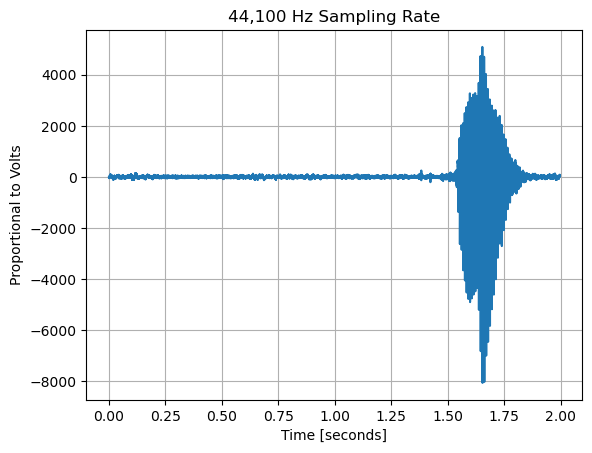

In [20]:
# STUDENT CODE HERE
fig, ax = plt.subplots()

ax.plot(times, samples)
ax.set_title("44,100 Hz Sampling Rate")
ax.set_xlabel("Time [seconds]")
ax.set_ylabel("Proportional to Volts")
ax.grid(True)

Then, plot every $441^\text{th}$ time and sample of the digital signal;
assuming the original sampling rate is the standard $f_s=44,100 \:\mathrm{Hz}$, this re-sampled signal would correspond to the case where we had used a sampling rate of only $f_s=100\:\mathrm{Hz}$.

Think about how we can create this low-rate, re-sampled signal by simply [slicing](https://www.pythonlikeyoumeanit.com/Module2_EssentialsOfPython/SequenceTypes.html#Slicing) into our original arrays of times and samples.

Label your axes and include units. The values that you recorded in your microphone aren't direct voltage measurements, but they are proportional to it – suffice it to label the $y$-axis as `"Proportional to Volts"`

Your x-axis (time) for this re-sampled figure should show the same overall duration as the original plot

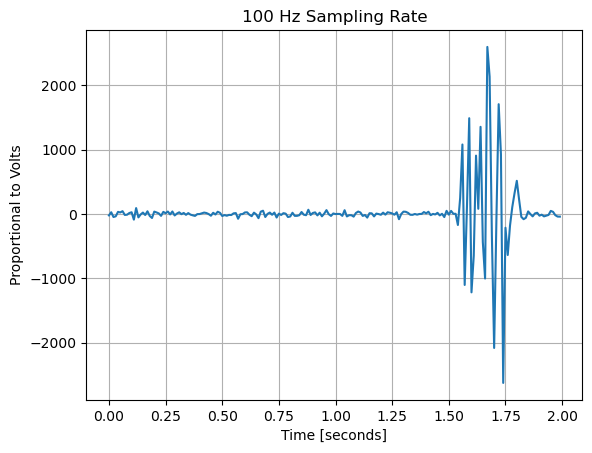

In [21]:
# STUDENT CODE HERE
fig, ax = plt.subplots()

low_sampled_times = times[::441]
low_sampled_samples = samples[::441]

ax.plot(low_sampled_times, low_sampled_samples)
ax.set_title("100 Hz Sampling Rate")
ax.set_xlabel("Time [seconds]")
ax.set_ylabel("Proportional to Volts")
ax.grid(True)

Try making new recordings (perhaps for longer durations). Try whistling, clapping, etc. Plot these digital signals and see if you can visually match the signals that you see with the audio that you recorded.

Congratulations! You created your own custom audio format, complete with functionality for saving and loading audio files!